### Import potrebných knižníc

In [1]:
from src.utils.coordinates_util import get_coordinates_for_city, haversine_distance
from src.scrapers.scrapers import BasicScraper
from src.types.types import Coordinates, URL, CSSSelector
from typing import List, Tuple
import seaborn as sns

import folium
import pandas as pd

### Overenie GPS súradníc
- Funkcia na overenie rovnosti dvoch sád GPS súradníc s určitým tolerančným rozpätím.
- Demonštruje použitie funkcie porovnávaním očakávaných a skutočných súradníc pre Trenčín.

In [2]:
def assert_gps_coordinates_equal(
    coord1: Coordinates, coord2: Coordinates, tolerance: float = 1e-2
):
    """
    Assert that two GPS coordinates are equal within a specified tolerance.

    Parameters:
    - coord1 (Coordinates): The first set of GPS coordinates.
    - coord2 (Coordinates): The second set of GPS coordinates.
    - tolerance (float): Tolerance level for latitude and longitude differences. Defaults to 1e-2.

    Raises:
    - AssertionError: If the latitude or longitude difference exceeds the specified tolerance,
      an AssertionError is raised with details about the differences.
    """
    assert (
        abs(coord1.latitude - coord2.latitude) < tolerance
    ), f"Latitude difference exceeds tolerance: {coord1.latitude} vs {coord2.latitude}"
    assert (
        abs(coord1.longitude - coord2.longitude) < tolerance
    ), f"Longitude difference exceeds tolerance: {coord1.longitude} vs {coord2.longitude}"


expected_coordinates: Coordinates = Coordinates(48.89452, 18.04436)


actual_coordinates: Coordinates = get_coordinates_for_city("Trenčín")


assert_gps_coordinates_equal(actual_coordinates, expected_coordinates)

### Načítanie a preskúmanie dát
- Načítanie datasetu obsahujúceho informácie o obciach na Slovensku - [Dataset](https://www.scitanie.sk/obyvatelia/zakladne-vysledky/pocet-obyvatelov/SR/SK0/OB)
- Kontrola velkosti dataframe-u

In [3]:
df: pd.DataFrame = pd.read_csv("data/obyvatelia_na_obec.csv")

assert df.shape[0] == 2927, "Number of municipalities doesn't match"
df.head(7)

,Kód,Územná jednotka,Spolu,muži (abs.),muži (%),ženy (abs.),ženy (%)
0,SK0101528595,Bratislava - mestská časť Staré Mesto,46080,22210,48.20,23870,51.80
1,SK0102529311,Bratislava - mestská časť Podunajské Biskupice,23464,11193,47.70,12271,52.30
2,SK0102529320,Bratislava - mestská časť Ružinov,81004,37575,46.39,43429,53.61
3,SK0102529338,Bratislava - mestská časť Vrakuňa,20711,9945,48.02,10766,51.98
4,SK0103529346,Bratislava - mestská časť Nové Mesto,44458,20981,47.19,23477,52.81
5,SK0103529354,Bratislava - mestská časť Rača,25733,12717,49.42,13016,50.58
6,SK0103529362,Bratislava - mestská časť Vajnory,6079,3056,50.27,3023,49.73


### Predspracovanie dát
- Výber potrebných stĺpcov
- Premenovanie stĺpcov

In [4]:
selected_columns: List[str] = ["Územná jednotka", "Spolu"]
df: pd.DataFrame = df[selected_columns]
df: pd.DataFrame = df.rename(columns={"Územná jednotka": "City", "Spolu": "Population"})

In [5]:
df.head(7)

,City,Population
0,Bratislava - mestská časť Staré Mesto,46080
1,Bratislava - mestská časť Podunajské Biskupice,23464
2,Bratislava - mestská časť Ružinov,81004
3,Bratislava - mestská časť Vrakuňa,20711
4,Bratislava - mestská časť Nové Mesto,44458
5,Bratislava - mestská časť Rača,25733
6,Bratislava - mestská časť Vajnory,6079


- Kontrola chýbajúcich hodnôt

In [6]:
assert df.isna().sum().sum() == 0, "data contains null values"

### Analýza obyvateľstva
- Zoskupenie a sčítanie obyvateľov pre jednotlivé časti Bratislavy a Košíc

In [7]:
bratislava_population: pd.DataFrame = df[df["City"].str.startswith("Bratislava")][
    "Population"
].sum()

kosice_population: pd.DataFrame = df[df["City"].str.startswith("Košice")][
    "Population"
].sum()


df_grouped: pd.DataFrame = pd.DataFrame(
    {
        "City": ["Bratislava", "Košice"],
        "Population": [bratislava_population, kosice_population],
    }
)

df_grouped

,City,Population
0,Bratislava,475503
1,Košice,229040


- Kombinácia dataframe-ov

In [8]:
df_dummy: pd.DataFrame = df[
    ~df["City"].str.startswith("Bratislava") & ~df["City"].str.startswith("Košice")
]

df_cities: pd.DataFrame = pd.concat([df_dummy, df_grouped], ignore_index=True)

df_cities.sort_values("Population", ascending=False).head()

,City,Population
2888,Bratislava,475503
2889,Košice,229040
2060,Prešov,84824
1215,Žilina,82656
729,Nitra,78489


### Webové scrapovanie informácií o predajniach Martinus
- Scrape-ovanie informácii o predajniach Martinus z webu, čistenie názvov miest a ulíc
- Overenie rovnosti počtu miest a ulíc proti očakávanej hodnote

In [9]:
martinus_website: URL = "https://www.martinus.sk/knihkupectva"

martinus_cities_path: CSSSelector = "div.card__content.mt-none h3"
martinus_streets_path: CSSSelector = "div.card__content.mt-none p:first-of-type"

martinus: BasicScraper = BasicScraper(martinus_website)

martinus_cities: List[str] = martinus.scrape(martinus_cities_path)

martinus_cities_clean: List[str] = [
    city.split("-")[0].strip() if "-" in city else city.split("(")[0].strip()
    for city in martinus_cities
]

martinus_streets: List[str] = martinus.scrape(martinus_streets_path)

martinus_streets_clean: List[str] = [
    street.split(",")[1].strip() if "," in street else street.strip()
    for street in martinus_streets
]

assert len(martinus_cities_clean) == len(
    martinus_streets_clean
), "Number of streets does not match number of cities"

assert (
    len(martinus_streets_clean) == 31
), "Scraped number of shops does not match the real number as of 7.1.2024"

### Zobrazenie adries predajní Martinusu
- Výpis adries pre vizuálnu kontrolu

In [10]:
martinus_adresses: List[Tuple] = [
    (city, street)
    for street, city in zip(martinus_streets_clean, martinus_cities_clean)
]

for adress in martinus_adresses:
    print(adress)

('Bratislava', 'Obchodná 26')
('Bratislava', 'Staré Grunty 24')
('Bratislava', 'Autobusová stanica Mlynské Nivy')
('Banská Bystrica', 'Ul. 29 augusta 37')
('Lučenec', 'Námestie republiky 5994/32')
('Zvolen', 'OC Klokan - Obchodná 10325/21')
('Banská Štiavnica', 'Radničné námestie 19')
('Revúca', 'Muránska ulica 1337/16')
('Rimavská Sobota', 'Francisciho 2')
('Košice', 'Toryská 5')
('Košice', 'Hlavná 111')
('Trebišov', 'M. R. Štefánika 2329')
('Levice', 'Ľ. Štúra 1A')
('Nitra', 'Akademická 1/A')
('Nitra', 'Napervillská 4837/5')
('Poprad', 'Námestie svätého Egídia 3290/124')
('Prešov', 'Námestie legionárov 1')
('Humenné', 'Nám. slobody 62')
('Kežmarok', 'Hviezdoslavova 10')
('Sabinov', 'Námestie slobody 32')
('Svidník', 'Sovietskych hrdinov 165/62')
('Považská Bystrica', 'Centrum 8')
('Ilava', 'Moyzesova 1871/123')
('Myjava', 'M.R.Štefánika 929')
('Nové Mesto nad Váhom', 'Weisseho 15/2615')
('Trnava', 'Dolné Bašty 8833/14')
('Liptovský Mikuláš', 'Kamenné pole 4449/3')
('Martin', 'Námesti

- Prevod do dataframe-u

In [11]:
df_cities_w_Martinus: pd.DataFrame = pd.DataFrame(martinus_adresses)

df_cities_w_Martinus.columns = ["City", "Street"]
df_cities_w_Martinus.head()

,City,Street
0,Bratislava,Obchodná 26
1,Bratislava,Staré Grunty 24
2,Bratislava,Autobusová stanica Mlynské Nivy
3,Banská Bystrica,Ul. 29 augusta 37
4,Lučenec,Námestie republiky 5994/32


### Geokódovanie adries predajní Martinusu
- GPS súradnice pre adresy predajní Martinusu
- Výpis miest, ktoré sa nepodarilo geokódovať

In [12]:
def get_coordinates_for_dataframe(df: pd.DataFrame) -> Tuple[pd.DataFrame, int]:
    """
    Get coordinates for a DataFrame by applying get_coordinates_for_address to each row.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with columns 'City' and 'Street'.

    Returns:
    - Tuple[pd.DataFrame, int]: A tuple containing the DataFrame with added 'Coordinates' column
      and the number of missing coordinates.
    """

    def get_coordinates_for_address(row):
        address = f"{row['Street']} {row['City']}"
        return get_coordinates_for_city(address)

    df["Coordinates"] = df.apply(get_coordinates_for_address, axis=1)
    missing_coordinates = df["Coordinates"].isna().sum().sum()

    return df, missing_coordinates

In [13]:
df_cities_w_Martinus, missing_coordinates = get_coordinates_for_dataframe(
    df_cities_w_Martinus
)

print(f"Number of missing coordinates: {missing_coordinates}")

df_cities_w_Martinus.head()

Coordinates not found for OC Klokan - Obchodná 10325/21 Zvolen
Coordinates not found for Stred 157- Srdce Turzovky Turzovka
Number of missing coordinates: 2


,City,Street,Coordinates
0,Bratislava,Obchodná 26,"(48.14718, 17.11001)"
1,Bratislava,Staré Grunty 24,"(48.1581155, 17.06974372915665)"
2,Bratislava,Autobusová stanica Mlynské Nivy,"(48.1468327, 17.128482)"
3,Banská Bystrica,Ul. 29 augusta 37,"(48.7363849, 19.1632147)"
4,Lučenec,Námestie republiky 5994/32,"(48.3307838, 19.6611366)"


- OC Klokan a Srdce Turzovky musia byť odstránene v špecifických prípadoch

In [14]:
df_cities_w_Martinus["Street"] = df_cities_w_Martinus["Street"].str.replace(
    r"\bOC\sKlokan\s-\s", "", regex=True
)

df_cities_w_Martinus["Street"] = df_cities_w_Martinus["Street"].str.replace(
    r"-\sSrdce Turzovky", "", regex=True
)

In [15]:
df_cities_w_Martinus, missing_coordinates = get_coordinates_for_dataframe(
    df_cities_w_Martinus
)

print(f"Number of missing coordinates: {missing_coordinates}")

df_cities_w_Martinus.head()

Number of missing coordinates: 0


,City,Street,Coordinates
0,Bratislava,Obchodná 26,"(48.14718, 17.11001)"
1,Bratislava,Staré Grunty 24,"(48.1581155, 17.06974372915665)"
2,Bratislava,Autobusová stanica Mlynské Nivy,"(48.1468327, 17.128482)"
3,Banská Bystrica,Ul. 29 augusta 37,"(48.7363849, 19.1632147)"
4,Lučenec,Námestie republiky 5994/32,"(48.3307838, 19.6611366)"


- Každý obchod má vlastnú adresu a vie byť zobrazený na mapu
- Disclaimer: Github nevie vykreslovať interaktívne grafy, preto je zobrazený iba jej screenshot pre plnú funkčnosť odporúčam notebook stiahnuť a odkomentovat časti kódu 'map'

In [16]:
def add_marker_to_map(
    coordinates_list: List[Coordinates], color: str, map_object: folium.Map
):
    """
    Add markers to a Folium map at specified coordinates.

    Parameters:
    - coordinates_list (List[tuple]): A list of coordinate tuples (latitude, longitude).
    - color (str): The color of the markers.
    - map_object (folium.Map): The Folium map object to which the markers will be added.

    Raises:
    - ValueError: If there is an error adding a marker, it raises a ValueError with an error message.
    """
    for coordinates in coordinates_list:
        try:
            lat, lon = coordinates[0], coordinates[1]

            marker = folium.Marker(
                location=[lat, lon],
                icon=folium.Icon(color=color),
            )
            map_object.add_child(marker)
        except Exception as e:
            raise ValueError(f"Error adding marker: {e}") from e

- Vykreslenie obchodov na mapu Slovenskej Republiky

In [17]:
martinus_map: folium.Map = folium.Map(location=[48, 20], zoom_start=8)

add_marker_to_map(df_cities_w_Martinus["Coordinates"], "red", martinus_map)

# martinus_map

![Slovakia Map](data/martinus.png)

- Môžeme vidieť, že niektoré časti mapy su prázdne, konkrétne Prievidza, Malacky a juh Slovenska

### Analýza obyvateľstva s predajňami Martinus
- Spája údaje o predajniach Martinus s údajmi o mestách
- Priemerný počet obyvateľov s predajňou Martinus
- Medián počtu obyvateľov
- Identifikuje mesto s najmenším obyvateľstvom, ktoré má predajňu Martinus.

In [18]:
df_cities_w_Martinus = pd.merge(df_cities_w_Martinus, df_cities, on="City", how="left")

df_cities_w_Martinus.sort_values("Population", ascending=False).head()

,City,Street,Coordinates,Population
0,Bratislava,Obchodná 26,"(48.14718, 17.11001)",475503
2,Bratislava,Autobusová stanica Mlynské Nivy,"(48.1468327, 17.128482)",475503
1,Bratislava,Staré Grunty 24,"(48.1581155, 17.06974372915665)",475503
9,Košice,Toryská 5,"(48.71498605, 21.238000791523028)",229040
10,Košice,Hlavná 111,"(48.72555895, 21.256622590976978)",229040


In [19]:
df_for_plotting = df_cities_w_Martinus.drop_duplicates(subset=["City"])

df_for_plotting["Population"].mean()

57693.11111111111

- Priemerný počet obyvateľov pre mestá s Martinusom je približne 58 tis. , treba si však uvedomiť , že Bratislava a Košice toto číslo skreslujú

In [20]:
df_for_plotting["Population"].median()

30522.0

- Použitie mediánu , t.j. 50. percentil nám dáva lepšiu predstavu o distribúcii

- Tieto čísla nám tu však veľa nehovoria lebo Slovensko je pomerne mále a do hĺbky sa neoplatí zachádzať, pre predstavu môžeme načrtnúť graf

<Axes: xlabel='Population', ylabel='Count'>

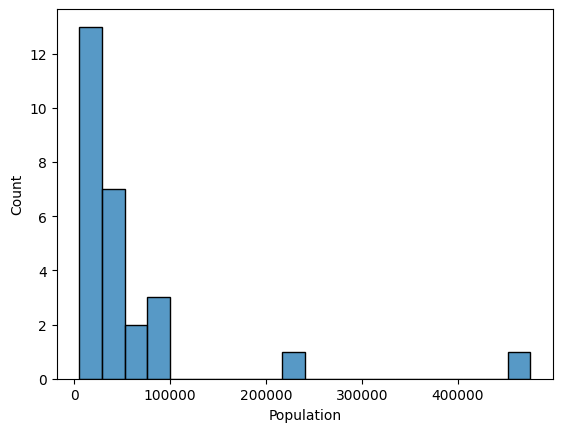

In [21]:
sns.histplot(df_for_plotting["Population"], bins=20)

- Väčšina miest má menej obyvaťelov ako medián a priemer, z tohto hľadiska pre novú predajňu, pozerať sa čisto len na počet obyvateľov nemá zmysel

In [22]:
min_population_index: int = df_cities_w_Martinus["Population"].idxmin()

min_population_city: pd.Series = df_cities_w_Martinus.loc[min_population_index]

f"{min_population_city['City']} is the smallest city ({min_population_city['Population']}) with Martinus"

'Ilava is the smallest city (5572) with Martinus'

- Najmenšie mesto, ktoré ma predajňu je Ilava, s počtom obyvateľov 5572, vzhľadom na to, že je to taktiež iba spriatelené knihkupectvo nepôjdeme do miest s menším počtom obyvateľov

In [23]:
df_cities_wo_Martinus: pd.DataFrame = df_cities[
    ~df_cities["City"].isin(martinus_cities_clean)
]

df_cities_wo_Martinus: pd.DataFrame = df_cities_wo_Martinus[
    df_cities_wo_Martinus["Population"] > min_population_city["Population"]
]

print(
    f"{df_cities_wo_Martinus.shape[0]} cities are bigger than Ilava and do not have Martinus"
)

df_cities_wo_Martinus.sort_values("Population", ascending=False).head()

93 cities are bigger than Ilava and do not have Martinus


,City,Population
562,Trenčín,54740
489,Prievidza,45017
791,Nové Zámky,37791
2584,Michalovce,36704
2770,Spišská Nová Ves,35431


- 93 miest je väčších ako Ilava ale len 31 má predajňu, necháme len obce , ktoré sú väčšie

In [24]:
df_cities_wo_Martinus["Coordinates"] = df_cities_wo_Martinus["City"].apply(
    get_coordinates_for_city
)

df_cities_wo_Martinus.head()

,City,Population,Coordinates
17,Malacky,18935,"(48.4362992, 17.0200447)"
21,Stupava,12595,"(48.273044, 17.0329528)"
32,Svätý Jur,5941,"(48.2541879, 17.2127253)"
34,Modra,9346,"(48.9450527, 22.0425486)"
35,Pezinok,24900,"(48.2854539, 17.270194)"


### Geokódovanie miest bez predajní Martinus
-  Pridanie súradnic pre mestá bez predajní Martinus

In [25]:
df_cities_wo_Martinus["Nearest_Martinus_km"] = df_cities_wo_Martinus.apply(
    lambda row: min(
        haversine_distance(row["Coordinates"], lib_row["Coordinates"])
        for _, lib_row in df_cities_w_Martinus.iterrows()
    ),
    axis=1,
)

df_cities_wo_Martinus["Nearest_Martinus_km"] = df_cities_wo_Martinus[
    "Nearest_Martinus_km"
].round(2)

df_cities_wo_Martinus.head()

,City,Population,Coordinates,Nearest_Martinus_km
17,Malacky,18935,"(48.4362992, 17.0200447)",31.15
21,Stupava,12595,"(48.273044, 17.0329528)",13.07
32,Svätý Jur,5941,"(48.2541879, 17.2127253)",13.47
34,Modra,9346,"(48.9450527, 22.0425486)",9.69
35,Pezinok,24900,"(48.2854539, 17.270194)",18.65


- Výpočet najbližšiej predajni pomocou GPS súradnic za využitia [Haversine-ovej rovnice](https://en.wikipedia.org/wiki/Haversine_formula)

In [26]:
df_cities_wo_Martinus.sort_values("Population", ascending=False).head()

,City,Population,Coordinates,Nearest_Martinus_km
562,Trenčín,54740,"(48.8922719, 18.0387465)",18.60
489,Prievidza,45017,"(48.7718361, 18.6234916)",37.91
791,Nové Zámky,37791,"(47.9861843, 18.1631415)",36.25
2584,Michalovce,36704,"(48.7514383, 21.9211949)",20.07
2770,Spišská Nová Ves,35431,"(48.9435344, 20.562964)",22.83


- Zobrazenie miest bez predajní Martinus, usporiadané podľa obyvateľstva (ako celok aj k najbližšej predajni Martinus)

In [27]:
df_cities_wo_Martinus.sort_values("Nearest_Martinus_km", ascending=False).head()

,City,Population,Coordinates,Nearest_Martinus_km
599,Komárno,32967,"(47.7574079, 18.1298249)",61.36
80,Veľký Meder,8446,"(47.8557806, 17.7693671)",56.05
609,Hurbanovo,7467,"(47.8761227, 18.198313)",47.68
842,Štúrovo,9777,"(47.7978002, 18.7158785)",46.97
615,Kolárovo,10572,"(47.9182347, 17.9966591)",44.14


- Lepšie je však podľa mna zohľadniť vzdialenosť , Trenčín ma najbližiu predajňu len 18km ale z Komárna človek musí zájsť až 61km

In [28]:
potential_shops: pd.DataFrame = df_cities_wo_Martinus.sort_values(
    "Nearest_Martinus_km", ascending=True
)[-5:].reset_index()

- Zobratie 5 miest, ktoré su najďalej od predajne

In [29]:
add_marker_to_map(potential_shops["Coordinates"], "green", martinus_map)
# martinus_map

![Candidates](data/candidates.png)

- Kandidáti sú na juhu Slovenska (`Komárno, Veľký Meder, Hurbanovo, Štúrovo, Kolárovo`) - zelené značky na mape
- Predpokladáme, že chceme momentálne postaviť len jednu predajňu
- Ak by sme ju dali do `Komárna`, kt. je najďalej a zároveň aj najväčie mesto, bolo by to nevýhodne pre zvyšné 4 mestá

In [30]:
coordinates: List[Coordinates] = potential_shops["Coordinates"].tolist()

mean_coordinates: Coordinates = tuple(map(lambda x: sum(x) / len(x), zip(*coordinates)))

print(mean_coordinates)

(47.84106922, 18.16200852)


- `Súradnice miest` spriemerujeme
- Výsledok je vyznačený *čiernou* značkou

In [31]:
add_marker_to_map([mean_coordinates], "black", martinus_map)
# martinus_map

![Average](data/GPS_average.png)

In [32]:
df_cities_wo_Martinus["Distance_to_Mean"] = df_cities_wo_Martinus["Coordinates"].apply(
    lambda coord: haversine_distance(mean_coordinates, coord)
)

nearest_city: pd.Series = df_cities_wo_Martinus.loc[
    df_cities_wo_Martinus["Distance_to_Mean"].idxmin()
]

print(nearest_city["City"])

Hurbanovo


- Avšak výsledná priemerná lokácia nie je úplne ideálna a tak predajňu posunieme do najbližieho mesta k nej, t.j. `Hurbanovo`

### Čo tak konkurencia?
- Na mapu nanesieme modrými značkami aj predajne `Panta Rhei`
- Podobný princíp scrape-ovania je použitý aj na stránku Panta Rhei

In [33]:
panta_rhei_website: URL = "https://www.pantarhei.sk/predajne/"
panta_rhei_shops_path: CSSSelector = "#html-body > main > div.container.overflow-hidden > div.row.mt-2.mt-md-3.fz-90-p.gutter-25px-sm > div > address"
panta_rhei = BasicScraper(panta_rhei_website)
panta_rhei_adresses: List[str] = panta_rhei.scrape(panta_rhei_shops_path)
panta_rhei_adresses: List[str] = [shop.strip() for shop in panta_rhei_adresses]

assert (
    len(panta_rhei_adresses) == 62
), "Scraped number does not match real number of shops as of 7.1.2024"

In [34]:
panta_rhei_adresses = [get_coordinates_for_city(shop) for shop in panta_rhei_adresses]

In [35]:
all_map = folium.Map(location=[48, 20], zoom_start=8)

hurbanovo: Coordinates = nearest_city["Coordinates"]

add_marker_to_map(df_cities_w_Martinus["Coordinates"], "red", all_map)
add_marker_to_map(panta_rhei_adresses, "blue", all_map)
add_marker_to_map([hurbanovo], "black", all_map)
# all_map

<img src="data/map_w_panta_rhei.png" alt="Map with all shops" width="1800"/>

### Záver
- `Hurbanovo` sa ukázalo ako najlepšia voľba
- V meste sa nechádza konkurencia
- Ostatné väčšie mestá sú pomerne blízko
- `Prievidza a Malacky`, spomenuté na začiatku, by mohli byť tiež dobrými kandidátmi (keďže pri zvážení 10 miest namiesto 5, boli medzi nimi a výsledným kandidátom boli `Šurany`).
- `Možnosti vylepšenia`: *HDP okresov*, *Zisk jednotlivých predajní*, *Vzdelanie okresov* , *Dostupnosť* , *Verejná doprava* a pod.